In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import *

%load_ext autoreload
%autoreload 2

#### Declare Variables 

In [344]:
n_states = 5 #number of states in the GMM
n_in = 1 #Number of variables for the radial basis function [s] (decay term)
n_out = 4 # Number of motion variables [xi,x2]

n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

#### Load Data 

(1000, 4)


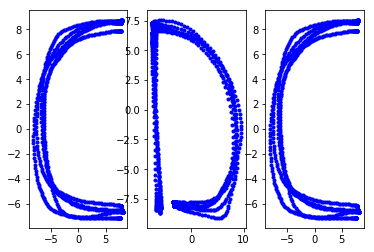

In [263]:
ROOT = 'python_data/2Dletters/'
data1 = np.load(ROOT + 'C.npy')[:n_samples]
data2 = np.load(ROOT + 'D.npy')[:n_samples]

#construct the output Y by concatenating all demonstrations in both dataset
data1 = data1.transpose([0,2,1])
data2 = data2.transpose([0,2,1])
data1 = np.concatenate(data1,axis=0)
data2 = np.concatenate(data2,axis=0)
Y = np.concatenate([data1,data2],axis=1)
print Y.shape

plt.subplot(1,3,1)
plt.plot(data1[:,0], data1[:,1],'.b')

plt.subplot(1,3,2)
plt.plot(data2[:,0], data2[:,1],'.b')

plt.subplot(1,3,3)
plt.plot(Y[:,0], Y[:,1],'.b')

#### Estimate GMM from the concatenated data [s_in, x_targets]

In [353]:
gmm = MFA(K = n_states,D = n_out,n_fac = 1)
gmm.fit(Y,max_iter = 100, n_init = 1, init_type = 'kmeans')

/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


Iteration 0
-7.0229633911804505
Iteration 1
-7.385823061494515
Iteration 2
-7.149260696483224
Iteration 3
-7.04121512739302
Iteration 4
-6.982808403369729
Iteration 5
-6.948489781489959
Iteration 6
-6.926363148620473
Iteration 7
-6.910796023321047
Iteration 8
-6.899210214758349
Iteration 9
-6.89024713359337
Iteration 10
-6.883118270656754
Iteration 11
-6.877324650301797
Iteration 12
-6.8725339574469055
Iteration 13
-6.868517264594782
Iteration 14
-6.865111605252602
Iteration 15
-6.862197194226546
Iteration 16
-6.859683497249598
Iteration 17
-6.857500503735273
Iteration 18
-6.855593048919966
Iteration 19
-6.853916989368995
Iteration 20
-6.852436552306426
Iteration 21
-6.851122449665792
Iteration 22
-6.849950501446789
Iteration 23
-6.848900606622632
Iteration 24
-6.847955957944635
Iteration 25
-6.84710243286196
Iteration 26
-6.8463281148897455
Iteration 27
-6.845622913544451
Iteration 28
-6.844978259760957
Iteration 29
-6.8443868595105375
Iteration 30
-6.843842492351951
Iteration 31
-6.8

[-10, 10, -10, 10]

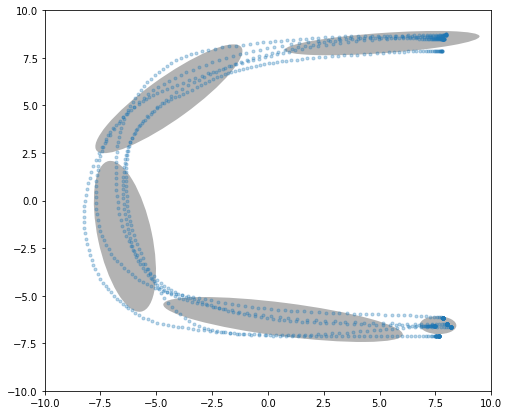

In [354]:
%matplotlib inline
fig = plt.figure(figsize=(8,7))
ax = fig.subplots()
plt.plot(Y[:,0], Y[:,1], '.', alpha=0.3)
plot_GMM(gmm.means_[:,:2], gmm.covariances_[:,:2,:2],ax)
plt.axis([-10,10,-10,10])

[-10, 10, -10, 10]

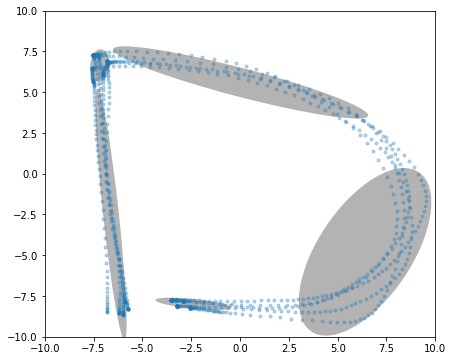

In [355]:
%matplotlib inline 
fig = plt.figure(figsize=(7,6))
ax = fig.subplots()
plt.plot(Y[:,2], Y[:,3], '.', alpha=0.3)
plot_GMM(gmm.means_[:,2:], gmm.covariances_[:,2:,2:],ax)
plt.axis([-10,10,-10,10])

In [352]:
from numpy import dot
from numpy.linalg import inv
class MFA(GMM):
    def __init__(self, D = 1, K = 2, n_fac = 1, reg_factor = 1e-6):
        self.D = D #number of dimensions
        self.K = K #number of mixture components
        self.L = -np.inf #total log likelihood
        self.weights_ = np.ones(K)/K
        self.means_ = np.random.rand(K,D)
        self.covariances_ = np.array([np.eye(D) for i in range(K)])
        
        self.Lambda_ = np.array([np.zeros((D,n_fac)) for i in range(K)])
        self.Psi_ = np.array([np.eye(D) for i in range(K)])
        self.n_fac = n_fac
        self.reg_factor = reg_factor
            
    def init_MFA(self):
        for k in range(self.K):
            self.Psi_[k] = np.diag(np.diag(self.covariances_[k]))
            D,V = np.linalg.eig(self.covariances_[k] - self.Psi_[k])
            indexes = np.argsort(D)[::-1]
            V = dot(V[:,indexes], np.diag(np.sqrt(D[indexes])))
            self.Lambda_[k] = V[:,:self.n_fac]
            
            B_k = dot(self.Lambda_[k].T, inv(dot(self.Lambda_[k],self.Lambda_[k].T)+self.Psi_[k]))
            self.Lambda_[k] = dot(self.covariances_[i],dot(B_k.T, inv(np.eye(self.n_fac)- dot(B_k,self.Lambda_[k]) + dot(B_k,dot(self.covariances_[i],B_k.T)))))
            self.Psi_[k] = np.diag(np.diag(self.covariances_[i] - dot(self.Lambda_[k], dot(B_k,self.covariances_[i])))) + np.eye(self.D)*self.reg_factor
           

    def fit(self,x, max_iter = 10, init_type = 'kmeans', threshold = 1e-4, n_init = 5):
        self.x = x
        self.N = len(self.x) #number of datapoints
        self.threshold = threshold
        
        best_params = ()
        Lmax = -np.inf

        for it in range(n_init):
            if init_type == 'kmeans':
                self.init_kmeans()
            elif init_type == 'random':
                self.init_random()

            self.init_MFA()
                
            for i in range(max_iter):
                print 'Iteration ' + str(i)
                self.expectation()
                self.maximization_1()
                self.expectation()
                
                self.maximization_2()
                print self.L
                if np.abs(self.prev_L-self.L) < self.threshold:
                    break
                    
            if self.L > Lmax:
                Lmax = self.L
                best_params = (self.L, self.weights_.copy(), self.means_.copy(), self.covariances_.copy(), self.zs.copy(), self.Ns.copy())
            
        #return the best result
        self.L = Lmax
        self.weights_ = best_params[1]
        self.means_ = best_params[2]
        self.covariances_ = best_params[3]
        self.zs = best_params[4]
        self.Ns = best_params[5]
        print 'Obtain best result with Log Likelihood: ' + str(self.L)
        
    def maximization_1(self):
        for k in range(self.K):
            #update weight
            self.weights_[k] = self.Ns[k]/self.N 
            #update mean
            self.means_[k,:] = np.dot(self.zs[:,k].T, self.x)/self.Ns[k]  

    def maximization_2(self):
        #update covariance
        for k in range(self.K):
            S_k = np.zeros((self.D,self.D))
            for i in range(self.N):
                S_k += self.zs[i,k]*np.outer(self.x[i,:]-self.means_[k,:], self.x[i,:].T-self.means_[k,:].T)
            S_k /= self.Ns[k]
            S_k += np.eye(self.D)*self.reg_factor
            B_k = dot(self.Lambda_[k].T, inv(dot(self.Lambda_[k],self.Lambda_[k].T)+self.Psi_[k]))
            
            
            self.Lambda_[k] = dot(S_k,dot(B_k.T, inv(np.eye(self.n_fac)- dot(B_k,self.Lambda_[k]) + dot(B_k,dot(S_k,B_k.T)))))
            self.Psi_[k] = np.diag(np.diag(S_k - dot(self.Lambda_[k], dot(B_k,S_k)))) + np.eye(self.D)*self.reg_factor
            
            self.covariances_[k] = dot(self.Lambda_[k], self.Lambda_[k].T) + self.Psi_[k]
            
    def plot(self):
        fig,ax = plt.subplots()
        plot_GMM(self.means_, self.covariances_, ax)